# **CIFAR-10 Object Recognition using ResNet50 architecture**





### 1.1. Load data


In [ ]:
%%time

from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

170498071/170498071 [==============================] - 13s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10
CPU times: user 6.11 s, sys: 1.24 s, total: 7.35 s
Wall time: 20.7 s


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [ ]:
%%time

# Scale the pixel values to the range [0, 1]
x_train_scaled = x_train / 255.0
x_test_scaled = x_test / 255.0

CPU times: user 219 ms, sys: 261 ms, total: 480 ms
Wall time: 476 ms


In [ ]:
%%time

# performing one-hot encoding

import numpy as np

def to_one_hot(y, num_classes=10):
    y_one_hot = np.zeros((len(y), num_classes))
    for i in range(len(y)):
        y_one_hot[i, y[i]] = 1
    return y_one_hot

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
CPU times: user 123 ms, sys: 111 µs, total: 123 ms
Wall time: 124 ms


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [ ]:
%%time

rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train_scaled[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train_scaled[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)
CPU times: user 151 ms, sys: 223 ms, total: 374 ms
Wall time: 372 ms


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * **Do NOT use test data for hyper-parameter tuning!!!**
3. Try to achieve a validation accuracy as high as possible.

### Remark:

The following CNN is just an naive example. You are supposed to make ***substantial improvements*** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

### **Basic CNN model:**

In [ ]:
%%time

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential

# Building the basic CNN model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               5

In [ ]:
%%time

from keras import optimizers

learning_rate = 1E-5 # defining the learning rate

# compiling the model:

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate),
              metrics=['accuracy'])

CPU times: user 29.1 ms, sys: 2.27 ms, total: 31.3 ms
Wall time: 34 ms


In [ ]:
%%time

# Fitting the model.
history = model.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 17s 6ms/step - loss: 2.1729 - accuracy: 0.2373 - val_loss: 2.0432 - val_accuracy: 0.3090
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9492 - accuracy: 0.3371 - val_loss: 1.8865 - val_accuracy: 0.3522
Epoch 3/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8289 - accuracy: 0.3767 - val_loss: 1.7946 - val_accuracy: 0.3811
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7528 - accuracy: 0.3946 - val_loss: 1.7349 - val_accuracy: 0.4022
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7002 - accuracy: 0.4101 - val_loss: 1.6863 - val_accuracy: 0.4119
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6577 - accuracy: 0.4215 - val_loss: 1.6510 - val_accuracy: 0.4161
Epoch 7/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.6218 - accuracy: 0.4329 - val_loss: 1.6186 - val_accuracy

In [ ]:
%%time

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test_vec)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 157.4614 - accuracy: 0.4412
Test Loss: 157.46139526367188
Test Accuracy: 0.44119998812675476
CPU times: user 1.24 s, sys: 132 ms, total: 1.37 s
Wall time: 1.31 s


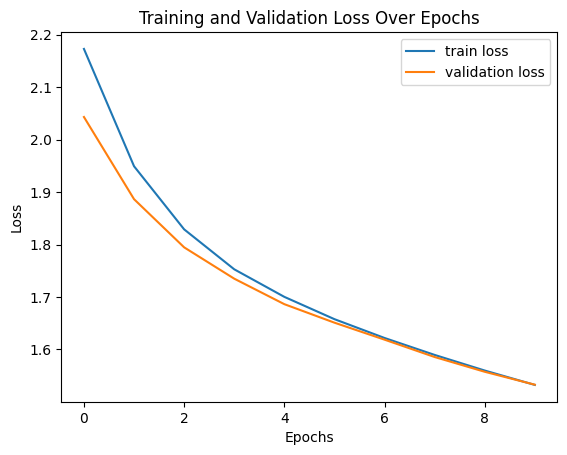

CPU times: user 260 ms, sys: 119 ms, total: 379 ms
Wall time: 272 ms


In [ ]:
%%time

import matplotlib.pyplot as plt
%matplotlib inline

# Plotting the training and validation loss value over epochs

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

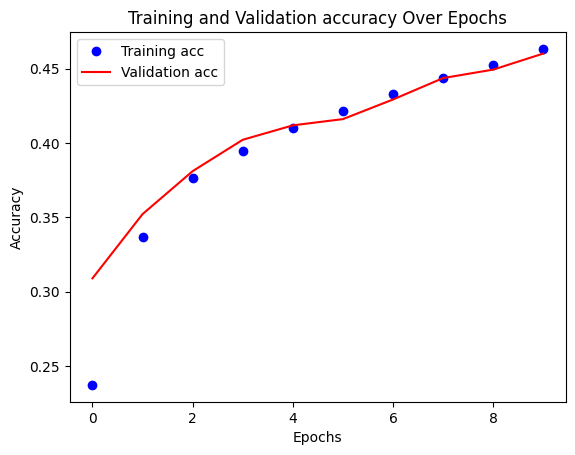

CPU times: user 265 ms, sys: 75.8 ms, total: 341 ms
Wall time: 298 ms


In [ ]:
%%time

# plotting training and validation accuracy over each epochs:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy Over Epochs')
plt.legend()
plt.show()

**Since our test accuracy is very low I will be using the ResNet50 CNN architecture.**

**ResNet50 CNN Model with validation data**


In [ ]:
%%time

# Importing necessary libraries

from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import cv2


CPU times: user 78.6 ms, sys: 28.8 ms, total: 107 ms
Wall time: 452 ms


In [ ]:
%%time

convolutional_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
convolutional_base.summary()


94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
%%time

# defining the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)


CPU times: user 68 µs, sys: 0 ns, total: 68 µs
Wall time: 74.1 µs


In [ ]:
%%time

# Building the CNN layers

num_of_classes = 10

model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(convolutional_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_of_classes, activation='softmax'))

CPU times: user 97.7 ms, sys: 1.79 ms, total: 99.5 ms
Wall time: 99.8 ms


In [ ]:
%%time

# compiling the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['acc'])

CPU times: user 26.2 ms, sys: 0 ns, total: 26.2 ms
Wall time: 26.4 ms


In [ ]:
%%time

# fitting the model
history_rn50 = model.fit(datagen.flow(x_tr, y_tr, batch_size=32), epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 582s 439ms/step - loss: 1.7918 - acc: 0.4108 - val_loss: 0.7946 - val_acc: 0.7685
Epoch 2/10
1250/1250 [==============================] - 548s 439ms/step - loss: 1.1121 - acc: 0.6583 - val_loss: 0.5148 - val_acc: 0.8594
Epoch 3/10
1250/1250 [==============================] - 548s 438ms/step - loss: 0.8434 - acc: 0.7656 - val_loss: 0.3716 - val_acc: 0.9044
Epoch 4/10
1250/1250 [==============================] - 547s 438ms/step - loss: 0.6949 - acc: 0.8190 - val_loss: 0.2895 - val_acc: 0.9217
Epoch 5/10
1250/1250 [==============================] - 548s 438ms/step - loss: 0.5786 - acc: 0.8586 - val_loss: 0.2572 - val_acc: 0.9269
Epoch 6/10
1250/1250 [==============================] - 544s 435ms/step - loss: 0.5080 - acc: 0.8772 - val_loss: 0.2258 - val_acc: 0.9357
Epoch 7/10
1250/1250 [==============================] - 547s 438ms/step - loss: 0.4425 - acc: 0.8961 - val_loss: 0.1981 - val_acc: 0.9449
Epoch 8/10
1250/1250 [============

In [ ]:
%%time

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test_scaled, y_test_vec)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 38s 120ms/step - loss: 0.1751 - acc: 0.9508
Test Loss: 0.17505130171775818
Test Accuracy: 0.9508000016212463
CPU times: user 5.68 s, sys: 2.03 s, total: 7.71 s
Wall time: 41.4 s


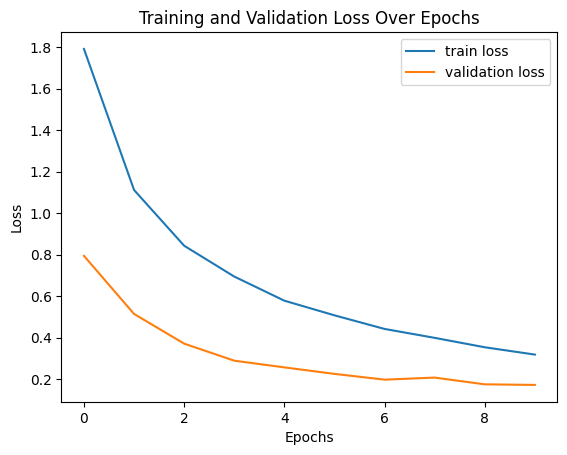

CPU times: user 294 ms, sys: 44.6 ms, total: 338 ms
Wall time: 302 ms


In [ ]:
%%time

# Plotting the loss value for training and validation over epochs:

plt.plot(history_rn50.history['loss'], label='train loss')
plt.plot(history_rn50.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

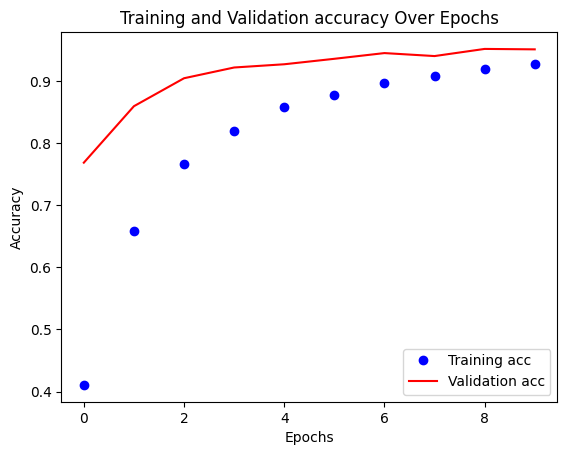

CPU times: user 279 ms, sys: 67.7 ms, total: 347 ms
Wall time: 352 ms


In [ ]:
%%time

# Training and Validation accuracy Over Epochs plot

acc = history_rn50.history['acc']
val_acc = history_rn50.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy Over Epochs')
plt.legend()
plt.show()


## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters.
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

- <Compile your model again (using the same hyper-parameters)>


- <Train your model on the entire training set (50K samples)>
- <Use (x_train, y_train_vec) instead of (x_tr, y_tr)>
- <Do NOT use the validation_data option (because now you do not have validation data)>


### Importing the dataset

**ResNet50 CNN model without validation data**

In [ ]:
%%time

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))


shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10
CPU times: user 898 ms, sys: 319 ms, total: 1.22 s
Wall time: 1.3 s


In [ ]:
%%time

# Scale the pixel values to the range [0, 1]
x_train_scaled = x_train / 255.0
x_test_scaled = x_test / 255.0

CPU times: user 225 ms, sys: 787 ms, total: 1.01 s
Wall time: 1.06 s


In [ ]:
%%time

# One-hot encoding for labels
def to_one_hot(y, num_classes=10):
    y_one_hot = np.zeros((len(y), num_classes))
    for i in range(len(y)):
        y_one_hot[i, y[i]] = 1
    return y_one_hot

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)


CPU times: user 126 ms, sys: 1.98 ms, total: 128 ms
Wall time: 130 ms


In [ ]:
%%time

# Load pre-trained ResNet50 model
convolutional_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

num_of_classes = 10


CPU times: user 1.61 s, sys: 70.4 ms, total: 1.68 s
Wall time: 1.67 s


In [ ]:
%%time

# Creating the model
model = Sequential()
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.UpSampling2D((2, 2)))
model.add(convolutional_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_of_classes, activation='softmax'))

# Compiling the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['acc'])


CPU times: user 44.8 ms, sys: 0 ns, total: 44.8 ms
Wall time: 44.4 ms


In [ ]:
%%time

# Training the model on the entire training set
history_rnet50 = model.fit(datagen.flow(x_train_scaled, y_train_vec, batch_size=32), epochs=10)


Epoch 1/10
1563/1563 [==============================] - 662s 406ms/step - loss: 1.6816 - acc: 0.4414
Epoch 2/10
1563/1563 [==============================] - 633s 405ms/step - loss: 0.9961 - acc: 0.7067
Epoch 3/10
1563/1563 [==============================] - 633s 405ms/step - loss: 0.7476 - acc: 0.8031
Epoch 4/10
1563/1563 [==============================] - 632s 405ms/step - loss: 0.6013 - acc: 0.8516
Epoch 5/10
1563/1563 [==============================] - 633s 405ms/step - loss: 0.5100 - acc: 0.8782
Epoch 6/10
1563/1563 [==============================] - 632s 404ms/step - loss: 0.4326 - acc: 0.9017
Epoch 7/10
1563/1563 [==============================] - 633s 405ms/step - loss: 0.3837 - acc: 0.9129
Epoch 8/10
1563/1563 [==============================] - 632s 405ms/step - loss: 0.3346 - acc: 0.9255
Epoch 9/10
1563/1563 [==============================] - 632s 405ms/step - loss: 0.3011 - acc: 0.9343
Epoch 10/10
1563/1563 [==============================] - 633s 405ms/step - loss: 0.2673 - a

In [ ]:
%%time

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test_scaled, y_test_vec)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


313/313 [==============================] - 38s 121ms/step - loss: 0.1495 - acc: 0.9569
Test Loss: 0.14951542019844055
Test Accuracy: 0.9569000005722046
CPU times: user 5.48 s, sys: 2.01 s, total: 7.49 s
Wall time: 41.6 s


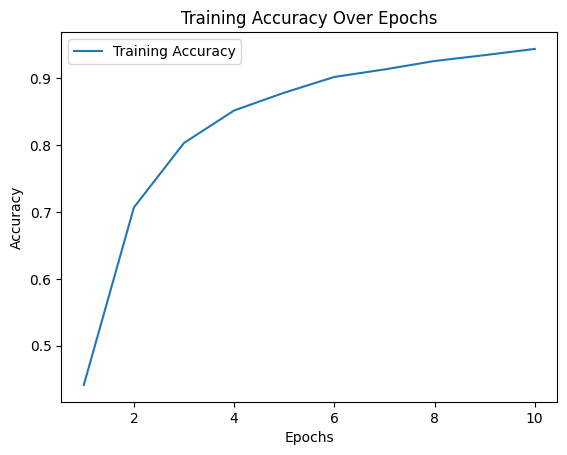

CPU times: user 220 ms, sys: 118 ms, total: 338 ms
Wall time: 208 ms


In [ ]:
%%time

# Access the training history
training_accuracy = history_rnet50.history['acc']  # Replace 'accuracy' with 'acc' if necessary

# Create a list of epoch numbers for x-axis
epochs = range(1, len(training_accuracy) + 1)

# Plot the training accuracy
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# **INFERENCE:**

**Normal Model:**

- Test Loss: 157.46
- Test Accuracy: 0.4412

**ResNet50 Model with Validation Data:**

- Test Loss: 0.1751
- Test Accuracy: 0.9508

**ResNet50 Model without Validation Data:**

- Test Loss: 0.1495
- Test Accuracy: 0.9569

**Explanation:**

The "Normal Model" seems to perform significantly worse, with a high test loss of 157.46 and a low test accuracy of 0.4412. This suggests that the normal model might not be suitable for this dataset.

The "ResNet50 Model with Validation Data" shows remarkable improvement. It achieved a much lower test loss of 0.1751 and a significantly higher test accuracy of 0.9508. This indicates that ResNet50, a deep convolutional neural network architecture, is highly effective for this dataset.

The "ResNet50 Model without Validation Data" exhibits similar excellent performance, with a slightly lower test loss of 0.1495 and a high test accuracy of 0.9569. This suggests that removing the validation data during training did not have a significant impact on the model's ability to generalize.

**About ResNet50:**

ResNet50 is a specific variant of the ResNet (Residual Network) architecture. It's known for its exceptional performance in various computer vision tasks, particularly image classification and object recognition. The key innovation in ResNet is the use of residual blocks, which include skip connections or shortcut connections. These skip connections allow gradients to flow more efficiently during training, which makes it possible to train very deep networks effectively.

**Reasons for Choosing ResNet50:**

- **Deep Architecture:** ResNet50 is a deep neural network with 50 layers, which allows it to capture intricate features and patterns in images. This is particularly important for complex image classification tasks.

- **Skip Connections:** The skip connections in ResNet alleviate the vanishing gradient problem, making it easier to train deep networks. This leads to faster convergence and better generalization.

- **Pre-trained Weights:** ResNet50 often comes with pre-trained weights on large image datasets like ImageNet. Transfer learning from such pre-trained models can save a lot of time and computational resources when training on smaller datasets.

- **High Accuracy:** ResNet50 is known for its high accuracy on a wide range of image classification tasks. It's a strong choice when you need a reliable and powerful model for image-related tasks.

In summary, I opted for the ResNet50 CNN model for its proven effectiveness in image classification, its ability to handle deep architectures, and the convenience of using pre-trained weights for transfer learning. The significant improvement in test accuracy compared to the normal model validates this choice.